#### Import Packages and read data

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, BatchNormalization, Input
from keras.metrics import Accuracy, mse
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

Using TensorFlow backend.


In [2]:
df=pd.read_csv("df_new.csv")

#### Set X and Y and make training and testing sets

In [3]:
Normaldat=df.loc[df["isFraud"]==0]
X=Normaldat[['amount', 'oldBalanceOrig', 'newBalanceOrig',
       'oldBalanceDest', 'newBalanceDest', 'errorBalanceOrig',
       'errorBalanceDest', 'day', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT',
       'TRANSFER', 'CC', 'CM', 'quartile1', 'quartile2', 'quartile3',
       'quartile4']]
Y=Normaldat["isFraud"]
#X=np.array(X)

In [4]:
df=df[['amount', 'oldBalanceOrig', 'newBalanceOrig',
       'oldBalanceDest', 'newBalanceDest', 'errorBalanceOrig',
       'errorBalanceDest', 'day', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT',
       'TRANSFER', 'CC', 'CM', 'quartile1', 'quartile2', 'quartile3',
       'quartile4','isFraud']]


In [5]:
SEED=42
X_train, X_test = train_test_split(df, test_size=0.2, random_state = SEED)

X_train = X_train[X_train['isFraud'] == 0]
X_train = X_train.drop(['isFraud'], axis=1)
y_test  = X_test['isFraud']
X_test  = X_test.drop(['isFraud'], axis=1)
#X_train = X_train.values
#X_test  = X_test.values

#### Scale Data

In [6]:
scaler=StandardScaler()
X_trainSc = scaler.fit_transform(X_train)
#X_trainSc=normalize(X_train)
X_testSc = scaler.transform(X_test)
#X_trainSc.shape

In [7]:
X_trainSc

array([[ 0.35089038,  1.32973737,  1.43679932, ..., -0.57770833,
        -0.57766623,  1.73503497],
       [ 0.05794289, -0.20710807, -0.13966794, ..., -0.57770833,
        -0.57766623,  1.73503497],
       [-0.2662738 , -0.28715725, -0.29259701, ...,  1.7309773 ,
        -0.57766623, -0.57635726],
       ...,
       [-0.28208694, -0.26787449, -0.27593916, ..., -0.57770833,
        -0.57766623, -0.57635726],
       [-0.17691532, -0.28138576, -0.29259701, ...,  1.7309773 ,
        -0.57766623, -0.57635726],
       [-0.14882408, -0.22047172, -0.25621226, ..., -0.57770833,
         1.73110344, -0.57635726]])

In [8]:
LABELS = ["Normal", "Fraud"]

In [9]:
input_dim=X_train.shape[1]

### First Neural Network Baseline Model

#### Create model instance

In [10]:
mod=Sequential()
mod.add(Dense(19,input_dim=19,activation='tanh'))
mod.add(Dense(9,activation='relu'))
mod.add(Dense(19,activation='tanh'))
mod.compile(loss='mse', optimizer='adam', metrics=["accuracy"])

In [11]:
mod.fit(X_trainSc,X_trainSc,validation_split=.2,epochs=10,batch_size=64)


Train on 4066802 samples, validate on 1016701 samples
Epoch 1/10
4066802/4066802 [==============================] - 175s 43us/step - loss: 0.3864 - accuracy: 0.4902 - val_loss: 0.3803 - val_accuracy: 0.5385
Epoch 2/10
4066802/4066802 [==============================] - 182s 45us/step - loss: 0.3812 - accuracy: 0.5518 - val_loss: 0.3801 - val_accuracy: 0.5538
Epoch 3/10
4066802/4066802 [==============================] - 155s 38us/step - loss: 0.3810 - accuracy: 0.5506 - val_loss: 0.3800 - val_accuracy: 0.5447
Epoch 4/10
4066802/4066802 [==============================] - 165s 41us/step - loss: 0.3809 - accuracy: 0.5774 - val_loss: 0.3800 - val_accuracy: 0.6224
Epoch 5/10
4066802/4066802 [==============================] - 168s 41us/step - loss: 0.3808 - accuracy: 0.5487 - val_loss: 0.3799 - val_accuracy: 0.5206
Epoch 6/10
4066802/4066802 [==============================] - 154s 38us/step - loss: 0.3807 - accuracy: 0.5132 - val_loss: 0.3798 - val_accuracy: 0.5140
Epoch 7/10
4066802/4066802 

In [12]:
mod.evaluate(X_testSc,X_testSc,batch_size=64)

1272524/1272524 [==============================] - 22s 17us/step


[0.3874873031762174, 0.5154457092285156]

#### Make Predictions

In [13]:
predictions = mod.predict(X_testSc)
mse = np.mean(np.power(X_testSc - predictions, 2), axis=1)


In [14]:
mse.shape

(1272524,)

In [15]:
errorDF=pd.DataFrame(mse)
errorDF.describe()

,0
count,1.272524e+06
mean,3.874873e-01
std,7.280732e+00
min,3.493837e-02
25%,4.628693e-02
50%,5.442725e-02
75%,8.382581e-02
max,2.274102e+03


#### Classifiy mse values higher than 5 as anomalies

In [16]:
y_pred = [1 if e > 5 else 0 for e in mse]

In [17]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270904
           1       0.01      0.08      0.01      1620

    accuracy                           0.99   1272524
   macro avg       0.50      0.54      0.50   1272524
weighted avg       1.00      0.99      0.99   1272524



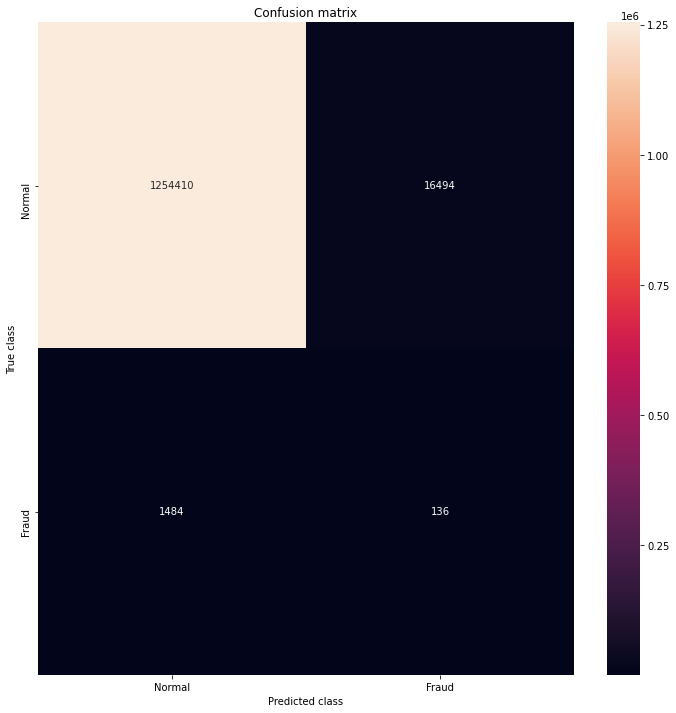

In [18]:

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Model 2 with min max scaler

In [19]:
model2=Sequential()

In [20]:
model2.add(Dense(10,input_dim=19,activation='relu'))
model2.add(Dense(2,activation='relu'))
model2.add(Dense(19,activation='relu'))
model2.compile(loss='mse', optimizer='adam', metrics=["accuracy"])

#### Use different Scaling Method

In [21]:
scaler=MinMaxScaler()
X_trainMM = scaler.fit_transform(X_train)
#X_trainSc=normalize(X_train)
X_testMM = scaler.transform(X_test)
#X_trainSc.shape
X_trainMM

array([[4.17959761e-03, 1.06565286e-01, 1.15732331e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.29820512e-03, 5.35465836e-03, 1.02341133e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.15992952e-04, 8.29323353e-05, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.14436485e-04, 1.35281946e-03, 1.11475422e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.89878651e-04, 4.63019854e-04, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.70288590e-04, 4.47458060e-03, 2.43489102e-03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [22]:
model2.fit(X_trainMM,X_trainMM,validation_split=.2,epochs=10,batch_size=64)

Train on 4066802 samples, validate on 1016701 samples
Epoch 1/10
4066802/4066802 [==============================] - 190s 47us/step - loss: 0.0816 - accuracy: 0.1819 - val_loss: 0.0807 - val_accuracy: 0.1714
Epoch 2/10
4066802/4066802 [==============================] - 181s 45us/step - loss: 0.0807 - accuracy: 0.1907 - val_loss: 0.0807 - val_accuracy: 0.1713
Epoch 3/10
4066802/4066802 [==============================] - 183s 45us/step - loss: 0.0807 - accuracy: 0.1919 - val_loss: 0.0807 - val_accuracy: 0.1714
Epoch 4/10
4066802/4066802 [==============================] - 171s 42us/step - loss: 0.0807 - accuracy: 0.1937 - val_loss: 0.0807 - val_accuracy: 0.1844
Epoch 5/10
4066802/4066802 [==============================] - 174s 43us/step - loss: 0.0807 - accuracy: 0.1943 - val_loss: 0.0807 - val_accuracy: 0.1714
Epoch 6/10
4066802/4066802 [==============================] - 174s 43us/step - loss: 0.0807 - accuracy: 0.1967 - val_loss: 0.0807 - val_accuracy: 0.1714
Epoch 7/10
4066802/4066802 [

#### Evaluate Model

In [23]:
model2.evaluate(X_testMM,X_testMM,batch_size=64)

1272524/1272524 [==============================] - 21s 17us/step


[0.0810774192777728, 0.1715095341205597]

In [24]:
predictions2 = model2.predict(X_testMM)
mse2 = np.mean(np.power(X_testMM - predictions2, 2), axis=1)


In [25]:
errorDF2=pd.DataFrame(mse2)
errorDF2.describe()

,0
count,1.272524e+06
mean,8.107742e-02
std,4.809518e-02
min,5.775979e-06
25%,5.322084e-02
50%,5.680235e-02
75%,1.078792e-01
max,1.816127e-01


#### Mark mse values greater than 3 as anomaly

In [26]:
y_pred2 = [1 if e > 3 else 0 for e in mse2]

In [27]:
y_pred2

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


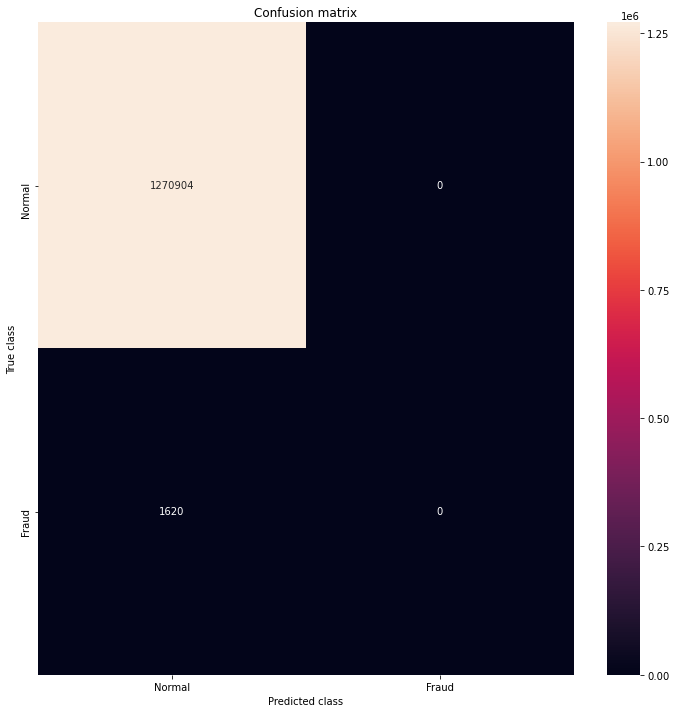

In [28]:
conf_matrix = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [29]:
print(classification_report(y_test,y_pred2))

C:\Users\glory\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.00      0.00      0.00      1620

    accuracy                           1.00   1272524
   macro avg       0.50      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524



In [30]:
y_test.value_counts()

0    1270904
1       1620
Name: isFraud, dtype: int64

### Model 3 more layers

In [31]:
model3=Sequential()

In [32]:
model3.add(Dense(19,input_dim=19,activation='relu'))
model3.add(Dense(10,activation='relu'))
model3.add(Dense(4,activation='relu'))
model3.add(Dense(10,activation='relu'))
model3.add(Dense(19,activation='relu'))
model3.compile(loss='mse', optimizer='adam', metrics=["accuracy"])

In [33]:
model3.fit(X_trainMM,X_trainMM,validation_split=.2,epochs=10,batch_size=64)

Train on 4066802 samples, validate on 1016701 samples
Epoch 1/10
4066802/4066802 [==============================] - 219s 54us/step - loss: 0.0369 - accuracy: 0.1872 - val_loss: 0.0361 - val_accuracy: 0.0823
Epoch 2/10
4066802/4066802 [==============================] - 228s 56us/step - loss: 0.0360 - accuracy: 0.1968 - val_loss: 0.0361 - val_accuracy: 0.1884
Epoch 3/10
4066802/4066802 [==============================] - 238s 58us/step - loss: 0.0360 - accuracy: 0.2008 - val_loss: 0.0361 - val_accuracy: 0.2545
Epoch 4/10
4066802/4066802 [==============================] - 232s 57us/step - loss: 0.0360 - accuracy: 0.2032 - val_loss: 0.0361 - val_accuracy: 0.2712
Epoch 5/10
4066802/4066802 [==============================] - 236s 58us/step - loss: 0.0360 - accuracy: 0.2035 - val_loss: 0.0361 - val_accuracy: 0.0652
Epoch 6/10
4066802/4066802 [==============================] - 284s 70us/step - loss: 0.0360 - accuracy: 0.2048 - val_loss: 0.0361 - val_accuracy: 0.1310
Epoch 7/10
4066802/4066802 [

In [34]:
model3.evaluate(X_testMM,X_testMM)

1272524/1272524 [==============================] - 47s 37us/step


[0.036056655890777736, 0.09195347130298615]

#### Not good enough accuracy, not moving forward

### Model 4 less layers using different activation

In [35]:
model4=Sequential()

In [36]:
model4.add(Dense(19,input_dim=19,activation='tanh'))
model4.add(Dense(4,activation='relu'))
model4.add(Dense(19,activation='tanh'))
model4.compile(loss='mse', optimizer='adam', metrics=["accuracy"])

In [37]:
history4=model4.fit(X_trainMM,X_trainMM,validation_split=.2,epochs=10,batch_size=64).history

Train on 4066802 samples, validate on 1016701 samples
Epoch 1/10
4066802/4066802 [==============================] - 173s 42us/step - loss: 0.0141 - accuracy: 0.4261 - val_loss: 0.0104 - val_accuracy: 0.4792
Epoch 2/10
4066802/4066802 [==============================] - 186s 46us/step - loss: 0.0104 - accuracy: 0.4792 - val_loss: 0.0104 - val_accuracy: 0.4792
Epoch 3/10
4066802/4066802 [==============================] - 213s 52us/step - loss: 0.0104 - accuracy: 0.4792 - val_loss: 0.0104 - val_accuracy: 0.4792
Epoch 4/10
4066802/4066802 [==============================] - 176s 43us/step - loss: 0.0104 - accuracy: 0.4792 - val_loss: 0.0104 - val_accuracy: 0.4792
Epoch 5/10
4066802/4066802 [==============================] - 180s 44us/step - loss: 0.0104 - accuracy: 0.4792 - val_loss: 0.0104 - val_accuracy: 0.4792
Epoch 6/10
4066802/4066802 [==============================] - 240s 59us/step - loss: 0.0104 - accuracy: 0.4792 - val_loss: 0.0104 - val_accuracy: 0.4792
Epoch 7/10
4066802/4066802 [

In [38]:
model4.evaluate(X_testMM,X_testMM)

1272524/1272524 [==============================] - 36s 28us/step


[0.010355501669921935, 0.7211809158325195]

In [39]:
predictions4 = model4.predict(X_testMM)
mse4 = np.mean(np.power(X_testMM - predictions4, 2), axis=1)


In [40]:
errorDF4=pd.DataFrame(mse4)
errorDF4.describe()

,0
count,1.272524e+06
mean,1.035550e-02
std,2.188117e-02
min,1.406590e-05
25%,1.324219e-03
50%,3.758831e-03
75%,6.854136e-03
max,1.751433e-01


#### Mark mse higher than .007 as anomaly

In [41]:
y_pred4 = [1 if e > .007 else 0 for e in mse4]

In [42]:
len(y_pred4)

1272524

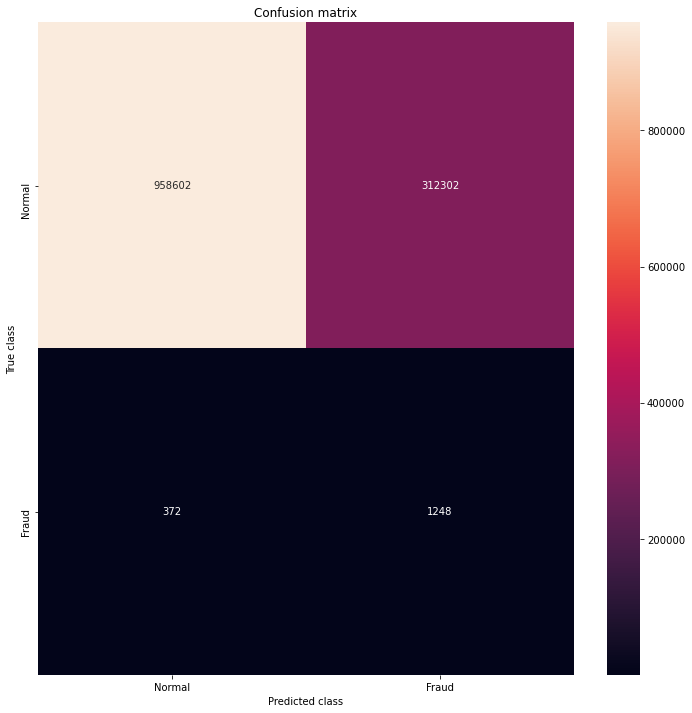

In [43]:
conf_matrix = confusion_matrix(y_test, y_pred4)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [44]:
print(classification_report(y_test,y_pred4))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86   1270904
           1       0.00      0.77      0.01      1620

    accuracy                           0.75   1272524
   macro avg       0.50      0.76      0.43   1272524
weighted avg       1.00      0.75      0.86   1272524



[Text(0, 0.5, 'Fraud'), Text(0, 1.5, 'Normal')]

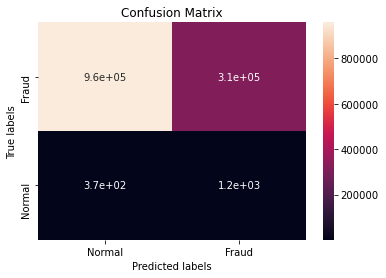

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Fraud']); ax.yaxis.set_ticklabels(['Fraud', 'Normal'])

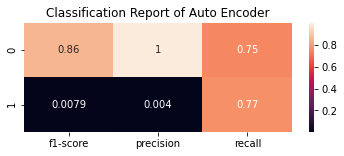

In [46]:
clf_report2 = classification_report(y_test, y_pred4, output_dict=True)
df = pd.DataFrame(clf_report2).iloc[:-1, :2].T

fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df, annot=True)
plt.title("Classification Report of Auto Encoder")
ax.set_ylim(len(df)+0, -0)
fig.savefig("file", bbox_inches = 'tight')
plt.show()

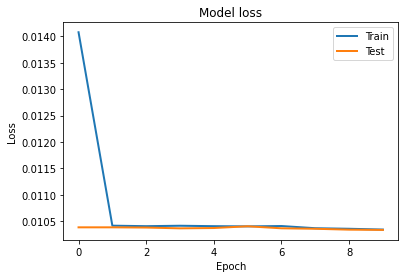

In [47]:
plt.plot(history4['loss'], linewidth=2, label='Train')
plt.plot(history4['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

### Model 5 all tanh

In [48]:
model5=Sequential()

In [49]:
model5.add(Dense(19,input_dim=19,activation='tanh'))
model5.add(Dense(4,activation='relu'))
model5.add(Dense(19,activation='tanh'))
model5.compile(loss='mse', optimizer='adam', metrics=["accuracy"])

In [50]:
model5.fit(X_trainMM,X_trainMM,validation_split=.2,epochs=30,batch_size=64)

Train on 4066802 samples, validate on 1016701 samples
Epoch 1/30
4066802/4066802 [==============================] - 208s 51us/step - loss: 0.1034 - accuracy: 2.3827e-04 - val_loss: 0.1029 - val_accuracy: 0.0000e+00
Epoch 2/30
4066802/4066802 [==============================] - 226s 55us/step - loss: 0.1029 - accuracy: 2.4589e-07 - val_loss: 0.1029 - val_accuracy: 0.0000e+00
Epoch 3/30
4066802/4066802 [==============================] - 261s 64us/step - loss: 0.1029 - accuracy: 2.4589e-07 - val_loss: 0.1029 - val_accuracy: 0.0000e+00
Epoch 4/30
4066802/4066802 [==============================] - 227s 56us/step - loss: 0.1029 - accuracy: 2.4589e-07 - val_loss: 0.1029 - val_accuracy: 0.0000e+00
Epoch 5/30
4066802/4066802 [==============================] - 211s 52us/step - loss: 0.1029 - accuracy: 2.4589e-07 - val_loss: 0.1029 - val_accuracy: 0.0000e+00
Epoch 6/30
4066802/4066802 [==============================] - 175s 43us/step - loss: 0.1029 - accuracy: 2.4589e-07 - val_loss: 0.1029 - val_a